# 1. Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn

from tqdm import tqdm_notebook

%load_ext google.cloud.bigquery

In [3]:
%%bigquery df

WITH clean AS 
(
SELECT 
  DISTINCT full_visitor_id , client_id , organization_uuid , country_id , session_id , session_start_time , session_end_time ,
  session_reached_minimal_created , 
  traffic_source_level_3 , traffic_source_source, traffic_source_medium,
  COUNT(DISTINCT organization_uuid) OVER(PARTITION BY full_visitor_id ) as nr_unique_uuid
FROM `izettle-dp-pipeline-prod.legacy_views.google_analytics_session` 
WHERE full_visitor_id NOT IN (--list of visitor id that has no client id and only one unique (NA) uuid and 
                          SELECT
                              full_visitor_id 
                          FROM (
                                SELECT
                                    DISTINCT full_visitor_id , client_id , organization_uuid  ,
                                    DENSE_RANK() OVER(PARTITION BY full_visitor_id ORDER BY client_id DESC, organization_uuid DESC) as rank_entry 
                                    #optimize the code by group by and array_agg()?
                                FROM `izettle-dp-pipeline-prod.legacy_views.google_analytics_session` 
                                WHERE full_visitor_id IN (SELECT 
                                                            DISTINCT full_visitor_id
                                                          FROM `izettle-dp-pipeline-prod.legacy_views.google_analytics_session` 
                                                          WHERE client_id IS NULL AND organization_uuid IS NULL
                                                          )
                                #ORDER BY full_visitor_id , rank_entry
                                      )
                          WHERE rank_entry = 1
                          AND client_id IS NULL
                          AND organization_uuid IS NULL
                          ) 
), 
ga_processed AS (
--delete row with no uuid and nr_unique_uuid per group of visitor id of that row > 1 
-- and fill NA uuid cells (Expected: rows with NA uuid and nr_unique_uuid =0 left)--
SELECT 
  full_visitor_id , client_id , organization_uuid , 
  IFNULL(organization_uuid, MAX(organization_uuid) OVER(PARTITION BY full_visitor_id)) as fill_uuid ,
  country_id , session_id , session_start_time , session_end_time ,
  session_reached_minimal_created ,
  traffic_source_level_3 , traffic_source_source, traffic_source_medium,
  nr_unique_uuid
FROM clean
WHERE 
  organization_uuid IS NOT NULL
  OR
  (organization_uuid IS NULL AND nr_unique_uuid <= 1)
),
merged_campaign AS(
SELECT
  full_visitor_id , 
  IFNULL(fill_uuid, MAX(campaign_data.organization_uuid) OVER(PARTITION BY client_id)) as fill_uuid_2,
  country_id , session_id , session_start_time , session_end_time ,
  session_reached_minimal_created ,
  traffic_source_level_3, traffic_source_source, traffic_source_medium
FROM ga_processed
LEFT JOIN (SELECT
              DISTINCT google_analytics_id , organization_uuid 
           FROM `izettle-dp-pipeline-prod.legacy_views.user_campaign_data`
           WHERE google_analytics_id IN (
                                         SELECT DISTINCT google_analytics_id
                                         FROM `izettle-dp-pipeline-prod.legacy_views.user_campaign_data`
                                         GROUP BY google_analytics_id 
                                         HAVING COUNT(DISTINCT organization_uuid) = 1
                                         ) 
          ) AS campaign_data
ON ga_processed.client_id = campaign_data.google_analytics_id 
),
merged_oc AS (
--customer journey of merchants until registration tracked by ga cookies--
--only ~ 245,000 merchants have the recorded journey. The rest that we have only the last touch point can be found in the customer_acquisition table--
SELECT
  ft.fill_uuid_2 as organization_uuid , oc.organization_created ,
  ft.full_visitor_id, ft.country_id , ft.session_id , ft.session_start_time , ft.session_end_time ,
  ft.session_reached_minimal_created ,
  ft.traffic_source_level_3,
  traffic_source_source, traffic_source_medium
FROM merged_campaign ft
LEFT JOIN `izettle-dp-pipeline-prod.legacy_views.organization_customer` oc
ON ft.fill_uuid_2 =oc.organization_uuid 
WHERE fill_uuid_2 IS NOT NULL
AND oc.organization_created >= ft.session_start_time 
)
SELECT
  uuid_left.organization_uuid ,
  uuid_left.organization_created ,
  #uuid_left.traffic_source_level_3 as traffic_source_level_3_af ,
  #merged_oc.full_visitor_id, 
  uuid_left.country_id , 
  #merged_oc.session_id , merged_oc.session_start_time , merged_oc.session_end_time ,
  merged_oc.session_reached_minimal_created ,
  #merged_oc.traffic_source_level_3,
  #merged_oc.traffic_source_source, merged_oc.traffic_source_medium,
  IFNULL(merged_oc.traffic_source_level_3, uuid_left.traffic_source_level_3) as traffic_source_full
FROM (
      SELECT 
        af.organization_uuid,
        af.traffic_source_level_3 , oc.organization_created , oc.country_id
      FROM `izettle-dp-pipeline-prod.legacy_views.attribution_funnel_traffic_source` af
      JOIN `izettle-dp-pipeline-prod.legacy_views.organization_customer` oc
      ON af.organization_uuid = oc.organization_uuid 
      AND oc.organization_created >= '2017-09-01'
      ) as uuid_left
LEFT JOIN merged_oc
ON uuid_left.organization_uuid = merged_oc.organization_uuid 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1735350 entries, 0 to 1735349
Data columns (total 5 columns):
organization_uuid                  object
organization_created               datetime64[ns, UTC]
country_id                         object
session_reached_minimal_created    object
traffic_source_full                object
dtypes: datetime64[ns, UTC](1), object(4)
memory usage: 66.2+ MB


In [5]:
%%bigquery df_af
SELECT 
  af.organization_uuid,
  oc.organization_created,
  oc.country_id,
  af.traffic_source_level_3 as traffic_source_full
FROM `izettle-dp-pipeline-prod.legacy_views.attribution_funnel_traffic_source` af
JOIN `izettle-dp-pipeline-prod.legacy_views.organization_customer` oc
ON oc.organization_uuid = af.organization_uuid
WHERE oc.organization_created >= '2017-09-01'            

In [5]:
df_af.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1135957 entries, 0 to 1135956
Data columns (total 4 columns):
organization_uuid       1135957 non-null object
organization_created    1135957 non-null datetime64[ns, UTC]
country_id              1135957 non-null object
traffic_source_full     1135957 non-null object
dtypes: datetime64[ns, UTC](1), object(3)
memory usage: 34.7+ MB


In [6]:
%%bigquery df_atc10
SELECT 
  DISTINCT organization_uuid 
FROM `izettle-dp-pipeline-prod.legacy_views.merchant_entity` 
WHERE organization_created >= '2017-09-01'
AND is_activated_10 IS True

In [7]:
df_atc10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280442 entries, 0 to 280441
Data columns (total 1 columns):
organization_uuid    280442 non-null object
dtypes: object(1)
memory usage: 2.1+ MB


# 2. Data Preparation

Some uuid (from GA tracking) cannt be traced the last touch point in GA. Pulling these last touch point from attribution_funnel

In [8]:
df_concat_1 = df[df['session_reached_minimal_created'].isna()]
df_concat_2 = df[df['session_reached_minimal_created'] == True] #duplicate here
df_concat_2 = df_concat_2.drop_duplicates('organization_uuid')

In [9]:
last_touch_ls = list(df_concat_2['organization_uuid'].unique()) + list(df_concat_1['organization_uuid'].unique())
df_concat_3 = df_af[~df_af['organization_uuid'].isin(last_touch_ls)]

In [10]:
df_concat_1 = df_concat_1.drop('session_reached_minimal_created', axis=1)
df_concat_2= df_concat_2.drop('session_reached_minimal_created', axis=1)

In [11]:
print(df_concat_1.info())
print(df_concat_2.info())
print(df_concat_3.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 432307 entries, 4 to 1735349
Data columns (total 4 columns):
organization_uuid       432307 non-null object
organization_created    432307 non-null datetime64[ns, UTC]
country_id              432307 non-null object
traffic_source_full     432307 non-null object
dtypes: datetime64[ns, UTC](1), object(3)
memory usage: 16.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 663594 entries, 3 to 1735348
Data columns (total 4 columns):
organization_uuid       663594 non-null object
organization_created    663594 non-null datetime64[ns, UTC]
country_id              663594 non-null object
traffic_source_full     663594 non-null object
dtypes: datetime64[ns, UTC](1), object(3)
memory usage: 25.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 40056 entries, 9 to 1135856
Data columns (total 4 columns):
organization_uuid       40056 non-null object
organization_created    40056 non-null datetime64[ns, UTC]
country_id           

In [12]:
df_full = pd.concat([df_concat_1, df_concat_2, df_concat_3], axis = 0, ignore_index=True)

In [13]:
list(df_full.traffic_source_full.unique())

['ds_inbound_inbound',
 'ds_keyaccount_keyaccount',
 'ps_other_partner',
 'o_paid_sem',
 'ps_bank_bank',
 'o_organic_app',
 'o_organic_seo',
 'o_paid_social',
 'o_organic_null',
 'o_organic_direct',
 'o_organic_invite',
 'o_paid_affiliate',
 'o_organic_referral',
 'o_paid_app_install',
 'ps_other_isc',
 'pp_paypal_paypal',
 'ps_product_api',
 'ps_other_local_partnership',
 'ps_pay_sdk',
 'ds_keyaccount_sdk']

In [14]:
dict_channels = {'ps_pay_sdk':'partnerships', 'ps_product_api':'partnerships', 'ps_bank_bank':'partnerships',
                'ps_other_local_partnership':'partnerships', 'ps_other_partner':'partnerships',
                 'ps_other_isc':'partnerships', 'pp_paypal_paypal':'partnerships',
                'ds_inbound_inbound':'direct','ds_keyaccount_sdk':'direct','ds_keyaccount_keyaccount':'direct'}

def map_value(df):
    df['traffic_source'] = ''
    for i in range(0, df.shape[0]):
        if df.traffic_source_full.iloc[i] in list(dict_channels.keys()):
            df['traffic_source'].iat[i] = dict_channels[df.traffic_source_full.iloc[i]]
        else: df['traffic_source'].iat[i] = df['traffic_source_full'].iat[i]

map_value(df_full)

In [16]:
basetable = df_full[df_full['organization_uuid'].isin(df_atc10['organization_uuid'])]
basetable.reset_index(inplace=True)

In [17]:
basetable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280442 entries, 0 to 280441
Data columns (total 6 columns):
index                   280442 non-null int64
organization_uuid       280442 non-null object
organization_created    280442 non-null datetime64[ns, UTC]
country_id              280442 non-null object
traffic_source_full     280442 non-null object
traffic_source          280442 non-null object
dtypes: datetime64[ns, UTC](1), int64(1), object(4)
memory usage: 12.8+ MB


# 3. Last touch model

## 3.1 Global

In [18]:
def last_touch(df):
    df_model = pd.DataFrame(df.traffic_source.value_counts())
    df_model.columns = ['conversion_abs']
    df_model['conversion_rate'] = df_model['conversion_abs']/df_model['conversion_abs'].sum()
    
    
    fig = plt.figure(figsize = (10,8))

    fig.add_subplot(2,1,1)
    plt.barh(y = df_model.index, width = 'conversion_rate', data = df_model, color = sbn.color_palette('tab20'))
    plt.title('Last touch attribution model')
    plt.xlabel('conversion rate')

    fig.add_subplot(2,1,2)
    plt.barh(y = df_model.index, width = 'conversion_abs', data = df_model, color = 'slateblue')
    plt.xlabel('abs number of conversion')

    plt.show()
    return df_model

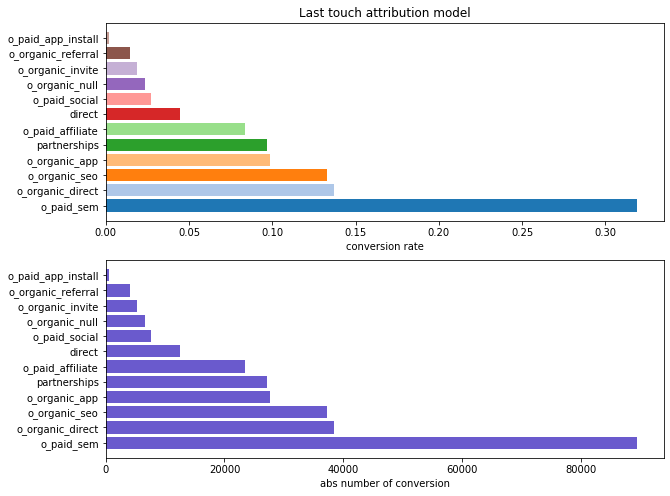

In [19]:
df_model = last_touch(basetable)

In [20]:
df_model

,conversion_abs,conversion_rate
o_paid_sem,89491,0.319107
o_organic_direct,38496,0.137269
o_organic_seo,37310,0.133040
o_organic_app,27637,0.098548
partnerships,27132,0.096747
o_paid_affiliate,23492,0.083768
direct,12443,0.044369
o_paid_social,7669,0.027346
o_organic_null,6692,0.023862
o_organic_invite,5317,0.018959


## 3.2 Monthly basic

In [21]:
basetable_m = basetable.assign(year_month = basetable.organization_created.dt.to_period('M'))

//anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


In [22]:
basetable_m.head()

,index,organization_uuid,organization_created,country_id,traffic_source_full,traffic_source,year_month
0,0,c86bbcc0-d0a3-11e7-8e84-d580513d4838,2017-11-23 23:12:31.884000+00:00,IT,ds_inbound_inbound,direct,2017-11
1,2,805f1370-b7ce-11e7-ba8a-4dd49cb4c1b2,2017-10-23 08:45:20.295000+00:00,IT,ds_inbound_inbound,direct,2017-10
2,4,28f9c6b0-d9b7-11e7-a769-14a76c0df6d1,2017-12-05 12:23:54.779000+00:00,IT,ds_inbound_inbound,direct,2017-12
3,5,a6496b10-58e3-11e8-8795-3443fe7b7b46,2018-05-16 08:32:20.545000+00:00,IT,ds_inbound_inbound,direct,2018-05
4,10,1cdfd4d0-ff7f-11e7-846d-7aeb7d92f669,2018-01-22 14:18:26.845000+00:00,IT,ds_inbound_inbound,direct,2018-01


In [23]:
def last_touch_m(df):
    df_group = pd.DataFrame(df.groupby('year_month')['traffic_source'].value_counts().unstack()).fillna(0)
    
    df_base = df_group.merge(pd.DataFrame(df_group.sum(axis = 1)),
                                      how = 'left',
                                      on = 'year_month')
    
    df_base.rename(columns = {0:'total_conversion'}, inplace = True)
    df_base.reset_index(inplace = True)
    
    base = pd.melt(df_base, id_vars = ['year_month','total_conversion'])
    base['conversion_rate'] = base['value']/base['total_conversion']
    
    return base.pivot(index = 'year_month', columns = 'variable', values = 'conversion_rate')

last_touch_m = last_touch_m(basetable_m)

In [24]:
last_touch_m

variable,direct,o_organic_app,o_organic_direct,o_organic_invite,o_organic_null,o_organic_referral,o_organic_seo,o_paid_affiliate,o_paid_app_install,o_paid_sem,o_paid_social,partnerships
year_month,,,,,,,,,,,,
2017-09,0.057454,0.026466,0.198744,0.037940,0.019514,0.017588,0.129983,0.061642,0.000754,0.314992,0.029397,0.105528
2017-10,0.061822,0.016939,0.208102,0.040824,0.013660,0.019514,0.126454,0.066818,0.001093,0.329561,0.030755,0.084459
2017-11,0.067298,0.023587,0.217315,0.038680,0.010781,0.020778,0.115910,0.069716,0.000784,0.306109,0.023848,0.105194
2017-12,0.045781,0.025543,0.241085,0.032911,0.009431,0.015227,0.102957,0.055408,0.001277,0.299047,0.042342,0.128991
2018-01,0.040549,0.029212,0.227160,0.031612,0.007117,0.015061,0.117428,0.064796,0.000828,0.320341,0.036329,0.109566
2018-02,0.038555,0.031979,0.219350,0.031168,0.009098,0.014053,0.121070,0.061976,0.000631,0.327808,0.040447,0.103865
2018-03,0.053188,0.037326,0.203204,0.031092,0.009470,0.012784,0.131392,0.082071,0.000947,0.312421,0.035354,0.090751
2018-04,0.038923,0.130235,0.103223,0.030515,0.013701,0.013312,0.130469,0.079714,0.002880,0.338627,0.017593,0.100810
2018-05,0.034495,0.166790,0.069286,0.030950,0.013665,0.013074,0.143374,0.082804,0.004137,0.327523,0.026001,0.087901


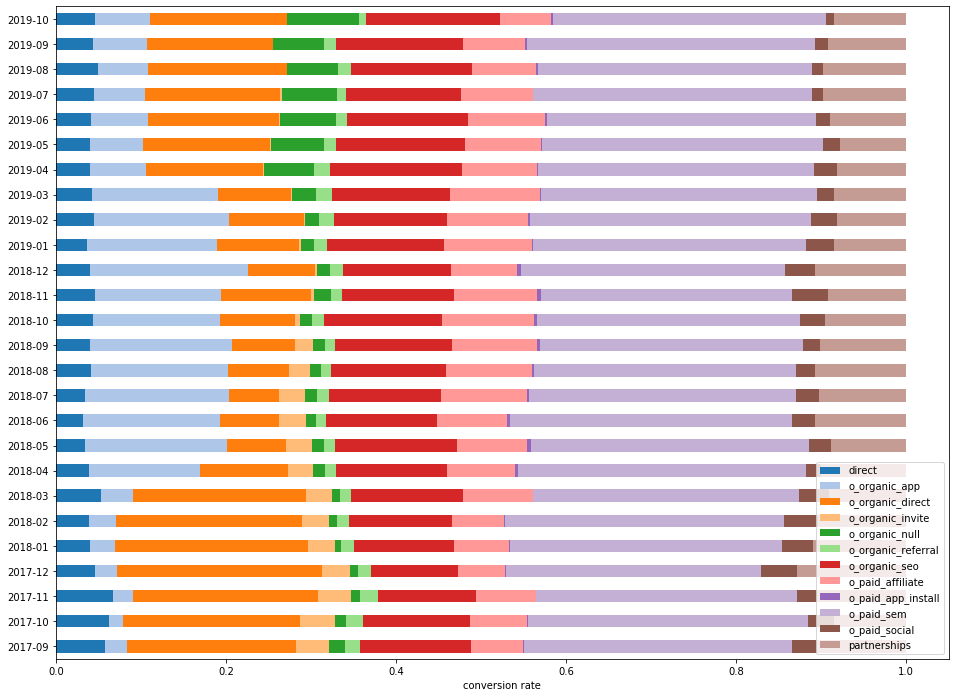

In [25]:
last_touch_m.plot.barh(stacked = True,
                         rot = 0,
                         figsize = (16,12),
                          color = sbn.color_palette('tab20'))
plt.xlabel('conversion rate')
plt.ylabel('')
plt.legend(loc = 'lower right')
plt.show()

## 3.3 Europe

In [26]:
country_list_euro = ['GB', 'FR', 'FI', 'NO', 'ES', 'NL', 'DE', 'DK', 'IT', 'SE']
basetable_europe = basetable[basetable['country_id'].isin(country_list_euro)]

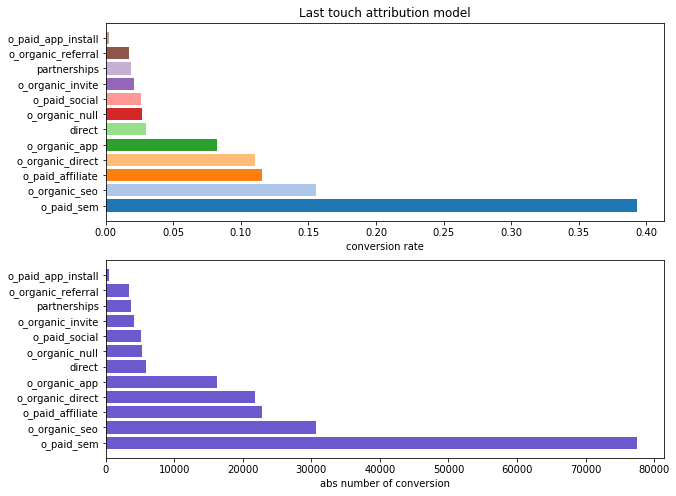

In [27]:
df_model_euro = last_touch(basetable_europe)

In [28]:
basetable_europe_m = basetable_europe.assign(year_month = basetable.organization_created.dt.to_period('M'))

In [29]:
def last_touch_m(df):
    df_group = pd.DataFrame(df.groupby('year_month')['traffic_source'].value_counts().unstack()).fillna(0)
    
    df_base = df_group.merge(pd.DataFrame(df_group.sum(axis = 1)),
                                      how = 'left',
                                      on = 'year_month')
    
    df_base.rename(columns = {0:'total_conversion'}, inplace = True)
    df_base.reset_index(inplace = True)
    
    base = pd.melt(df_base, id_vars = ['year_month','total_conversion'])
    base['conversion_rate'] = base['value']/base['total_conversion']
    
    return base.pivot(index = 'year_month', columns = 'variable', values = 'conversion_rate')

In [30]:
europe_m = last_touch_m(basetable_europe_m)

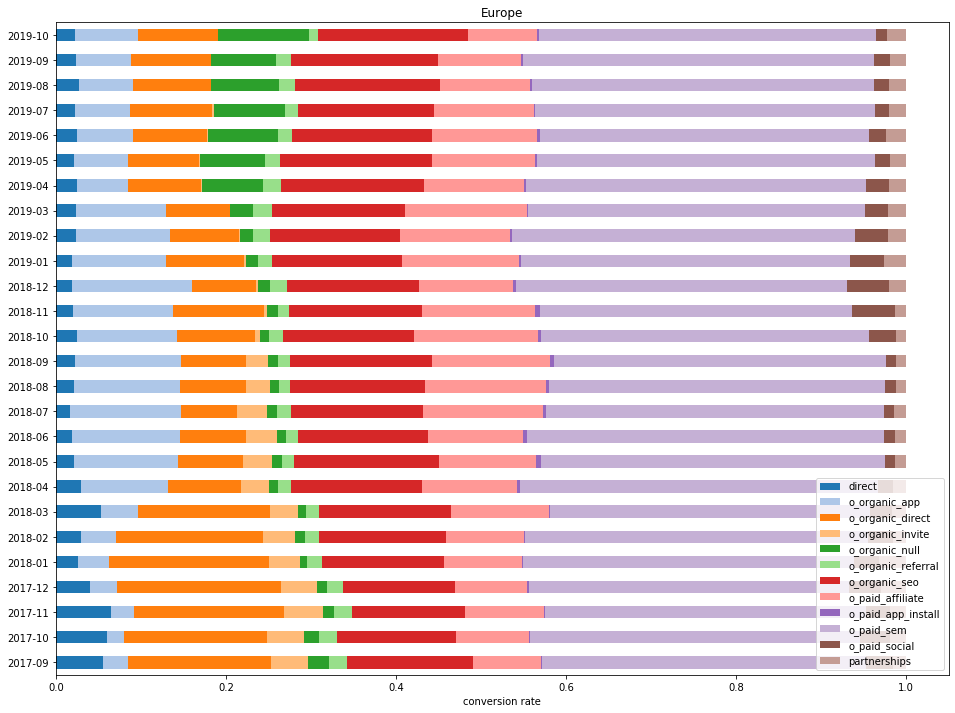

In [31]:
europe_m.plot.barh(stacked = True,
                         rot = 0,
                         figsize = (16,12),
                          color = sbn.color_palette('tab20'))
plt.xlabel('conversion rate')
plt.ylabel('')
plt.legend(loc = 'lower right')
plt.title('Europe')
plt.show()

In [32]:
europe_m

variable,direct,o_organic_app,o_organic_direct,o_organic_invite,o_organic_null,o_organic_referral,o_organic_seo,o_paid_affiliate,o_paid_app_install,o_paid_sem,o_paid_social,partnerships
year_month,,,,,,,,,,,,
2017-09,0.055466,0.029590,0.167389,0.044076,0.025009,0.020428,0.148570,0.080228,0.000990,0.380834,0.031571,0.015847
2017-10,0.060272,0.020318,0.167537,0.043133,0.017594,0.021339,0.139728,0.086266,0.001589,0.388195,0.034393,0.019637
2017-11,0.064326,0.027679,0.176488,0.045231,0.012923,0.021989,0.132028,0.092777,0.001157,0.378050,0.027775,0.019578
2017-12,0.040368,0.031014,0.192977,0.042337,0.012471,0.018543,0.131769,0.085002,0.002133,0.376436,0.036922,0.030030
2018-01,0.026264,0.036082,0.188390,0.035837,0.008346,0.017796,0.144207,0.091679,0.001227,0.388316,0.029455,0.032401
2018-02,0.029663,0.041416,0.172800,0.037638,0.011194,0.016930,0.149573,0.091507,0.000840,0.403806,0.028683,0.015951
2018-03,0.052589,0.044207,0.154553,0.033758,0.009186,0.014583,0.155357,0.115513,0.001148,0.376277,0.026065,0.016764
2018-04,0.029287,0.102951,0.084842,0.033311,0.010396,0.015314,0.154482,0.111558,0.003912,0.420635,0.017438,0.015873
2018-05,0.021039,0.122071,0.076346,0.034892,0.011561,0.014165,0.170711,0.114259,0.005624,0.404020,0.011770,0.013540
